# Metacritic Comments and Scores
This dataset is a web scrape of Metacritic user comments and reviews by Dahlia at kaggle.com. Metacritic is a review aggregator for movies, TV shows, music albums, and video games.

Source: https://www.kaggle.com/dahlia25/metacritic-video-game-comments, accessed on July 26th, 2020.

The web scraper can be found at https://github.com/dahlia25/game_recommender, and uses Selenium and BeautifulSoup.

The data range between 1998 and 2018.

## The Dataset
Number of Rows | Number of Columns | One Row Represents
------------- | ------------- | -------------
283,983 | 5 | One user review

## Sentiment Analysis

First, we will conduct a sentiment analysis on Metacritic reviews for Nintendo 64 games. Sentiment is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. In this case, we will attempt to determine whether a review is postive or negative based on the language used.

In [20]:
#Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    print("Module 'wordcloud' is installed")
except ModuleNotFoundError:
    %pip install wordcloud
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

try:
    import nltk
    print("Module 'nltk' is installed")
except ModuleNotFoundError:
    %pip install nltk
    import nltk
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet
from nltk.sentiment import SentimentIntensityAnalyzer

import re, string

import random

import math  

Module 'wordcloud' is installed
Module 'nltk' is installed


In [21]:
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub("https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", "", token) #Remove hyperlinks of http[s] variety
        token = re.sub("(@[A-Za-z0-9_]+)", "", token) #Remove Twitter @'s
        if tag.startswith("NN"):
            pos = wordnet.NOUN
        elif tag.startswith("VB"):
            pos = wordnet.VERB
        elif tag.startswith("JJ"):
            pos = wordnet.ADJ
        else:
            pos = wordnet.ADV

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def prepare_for_model(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tokens)

def is_positive(token):
    return sia.polarity_scores(token)["compound"] > 0


We will be relying on VADER, a pre=trained model typically used for social media sentiment analysis, as a starting point for determining sentiment.
It's a good starting point, but it's easy to anticipate problems: many reviews on Metacritic are sarcastic, and VADER will not be able to determine the difference
between a sarcastic negative review and a positive one. It might be worth it to cut down the dataset and manually enter positive or negative for each review.

In [22]:
nltk.download("twitter_samples")
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\arqui\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arqui\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arqui\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\arqui\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arqui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\arqui\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is

True

In [23]:
dfN64 = pd.read_csv("Datasets/n64.csv", index_col = 0)

In [24]:
stop_words = stopwords.words('english')

tokenizer = TweetTokenizer()

#n64Text = dfN64["Comment"].str.cat(sep = " ")
n64Comments = []
for comment in dfN64["Comment"]:
    n64Comments.append(tokenizer.tokenize((comment)))

print(n64Comments[0])

['Everything', 'in', 'OoT', 'is', 'so', 'near', 'at', 'perfection', ',', 'its', 'really', 'no', 'wonder', 'that', 'this', 'game', 'has', 'such', 'a', 'huge', 'fanbase', 'and', 'is', 'so', 'highly', 'rated', 'among', 'players', 'and', 'critics', '.']


In [25]:
#print(pos_tag(n64Comments[0]))

In [26]:
cleanedN64CommentsTokens = []
for token in n64Comments:
    cleanedN64CommentsTokens.append(remove_noise(token, stop_words))
print(cleanedN64CommentsTokens[0])

['everything', 'oot', 'near', 'perfection', 'really', 'wonder', 'game', 'huge', 'fanbase', 'highly', 'rat', 'among', 'player', 'critic']


In [27]:
sia = SentimentIntensityAnalyzer()

cleanedN64PositiveCommentsWhole = []
for tokenizedComment in cleanedN64CommentsTokens:
    cleanedN64PositiveCommentsWhole.append(" ".join(tokenizedComment))
positiveN64 = [(token, "Positive") for token in cleanedN64PositiveCommentsWhole if sia.polarity_scores(token)["compound"] > 0]
#print(positiveN64[0])

positiveN64Tokens = []
for comment in positiveN64:
    positiveN64Tokens.append(tokenizer.tokenize((comment[0])))
#print(positiveN64Tokens[0])

#------------

cleanedN64NegativeCommentsWhole = []
for tokenizedComment in cleanedN64CommentsTokens:
    cleanedN64NegativeCommentsWhole.append(" ".join(tokenizedComment))
negativeN64 = [(token, "Negative") for token in cleanedN64NegativeCommentsWhole if sia.polarity_scores(token)["compound"] < 0]
#print(negativeN64[1])

negativeN64Tokens = []
for comment in negativeN64:
    negativeN64Tokens.append(tokenizer.tokenize((comment[0])))
#print(negativeN64Tokens[1])

#------------

cleanedN64NeutralCommentsWhole = []
for tokenizedComment in cleanedN64CommentsTokens:
    cleanedN64NeutralCommentsWhole.append(" ".join(tokenizedComment))
neutralN64 = [(token, "Neutral") for token in cleanedN64NeutralCommentsWhole if sia.polarity_scores(token)["compound"] == 0]
#print(neutralN64[1])

neutralN64Tokens = []
for comment in neutralN64:
    neutralN64Tokens.append(tokenizer.tokenize((comment[0])))
#print(neutralN64Tokens[1])

In [28]:
positiveForModel = prepare_for_model(positiveN64Tokens)
negativeForModel = prepare_for_model(negativeN64Tokens)
neutralForModel = prepare_for_model(neutralN64Tokens)

positiveN64Dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positiveForModel]

negativeN64Dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negativeForModel]

neutralN64Dataset = [(tweet_dict, "Neutral")
                     for tweet_dict in neutralForModel]


print(positiveN64Dataset[0])

({'everything': True, 'oot': True, 'near': True, 'perfection': True, 'really': True, 'wonder': True, 'game': True, 'huge': True, 'fanbase': True, 'highly': True, 'rat': True, 'among': True, 'player': True, 'critic': True}, 'Positive')


In [29]:
dataset = positiveN64Dataset + negativeN64Dataset #+ neutralN64Dataset | Leaving out for now as it contains foreign languages

random.shuffle(dataset)
print(len(dataset))

math.floor(len(dataset) * .7)
math.floor(len(dataset) * .7)

train_data = dataset[ : math.floor(len(dataset) * .7) ]
test_data = dataset[ math.floor(len(dataset) * .7) : ]

#train_data[0]

2290


In [30]:
#positiveFreqDist = FreqDist(allN64Words)
#print(positiveFreqDist.most_common(10))

In [31]:
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(25))

Accuracy is: 0.8500727802037845
Most Informative Features
                    0/10 = True           Negati : Positi =     26.3 : 1.0
                   idiot = True           Negati : Positi =     26.3 : 1.0
                      si = True           Negati : Positi =     26.3 : 1.0
                     sin = True           Negati : Positi =     20.3 : 1.0
                   chase = True           Negati : Positi =     18.8 : 1.0
                 correct = True           Negati : Positi =     18.8 : 1.0
                   dance = True           Negati : Positi =     18.8 : 1.0
                  fanboy = True           Negati : Positi =     18.8 : 1.0
                     fue = True           Negati : Positi =     18.8 : 1.0
                    limb = True           Negati : Positi =     18.8 : 1.0
                meilleur = True           Negati : Positi =     18.8 : 1.0
                     pas = True           Negati : Positi =     18.8 : 1.0
                    pour = True           

The output can be read as the ratio for negative to positives for each word, e.g. cheap has a ratio of 26.6 to 1 for positive and negative tweets.

In [32]:
#df = pd.read_csv("D:/Git/large datasets/metacritic_game_user_comments.csv", index_col = 0)
#dfN64 = df[df["Platform"] == "Nintendo64"]
#dfN64.to_csv("D:/Git/jupyter-books/Datasets/n64.csv")

## Wordcloud
Next, we will make a wordcloud to see the most commonly used words.

In [33]:
dfN64 = pd.read_csv("Datasets/n64.csv", index_col = 0)

In [34]:
dfN64.head()

,Title,Platform,Userscore,Comment,Username
0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"Everything in OoT is so near at perfection, it...",SirCaestus
1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I won't bore you with what everyone is already...,Kaistlin
2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Anyone who gives the masterpiece below a 7 or ...,Jacody
3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm one of those people who think that this is...,doodlerman
4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,This game is the highest rated game on Metacr...,StevenA


In [35]:
n64Text = dfN64["Comment"].str.cat(sep = " ")

stopwords = set(STOPWORDS)
stopwords.update(["game", "play", "played", "to", "feel", "even", "want", "make", "made", "much", "still", "playing", "one", "games"])

cloud = WordCloud(width = 1200, height = 800, stopwords = stopwords, background_color = "white").generate(n64Text)

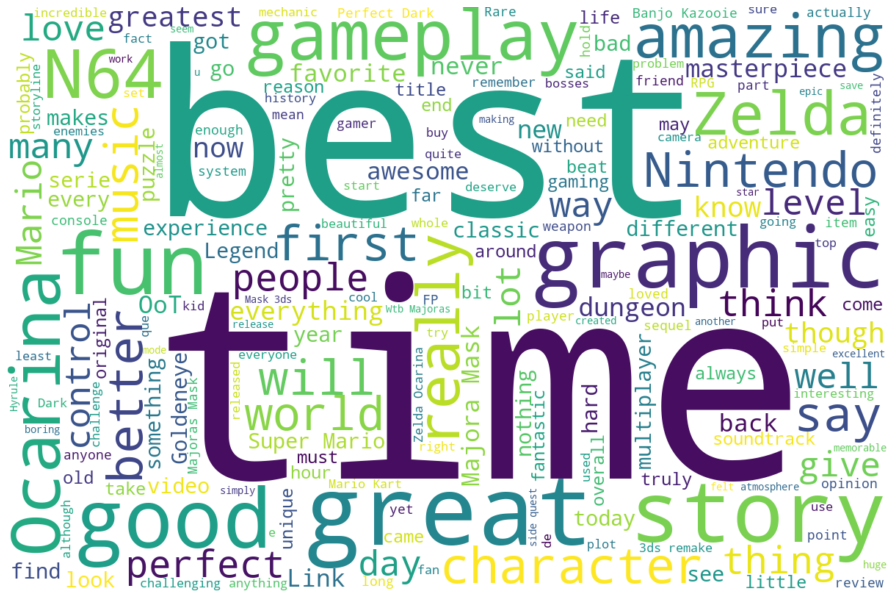

In [36]:
plt.figure(figsize = (19.2, 10.8))
plt.imshow(cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

A couple words of note are story, graphic, and gameplay. Time appears to be the most common, but this is certainly due to the game Legend of Zelda: Ocarina of Time, which is incredibly popular and has many, many reviews. There are other words shown that are also related to the Legend of Zelda, like Link, Zelda, and Hyrule.